In [1]:
from google.cloud import bigquery

client = bigquery.Client(project='datamanagementbi')
tabla_completa = 'datamanagementbi.gold_data.modelo_final'
tabla = client.get_table(tabla_completa)

query = """
    SELECT *
    FROM `datamanagementbi.gold_data.modelo_final`
"""

df = client.query(query).to_dataframe()

/opt/miniconda3/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
# ============================================================================
# 1. ANÁLISIS UNIVARIADO: ¿QUÉ VARIABLE EXPLICA MÁS?
# ============================================================================

print("\n📊 1. PODER EXPLICATIVO DE CADA VARIABLE")
print("=" * 80)

# Calcular R² para cada variable categórica (usando varianza explicada)
from sklearn.metrics import r2_score

variables_categoricas = {
    'Sector': 'id_sector_economico',
    'Tramo Horario': 'id_tramo_horario',
    'Fin de Semana': 'es_fin_de_semana',
    'Festivo': 'es_festivo',
    'Mes': 'mes',
    'Día del Mes': 'dia_del_mes',
    'Código Postal': 'id_geografia',
    'Año': 'anio'
}

variables_numericas = {
    'Temperatura': 'temperatura_media_ciudad',
    'Humedad': 'humedad_media_ciudad',
    'Población': 'poblacion'
}

resultados = []

# Analizar variables categóricas
for nombre, columna in variables_categoricas.items():
    if columna in df.columns:
        # Usar la media por grupo como predicción
        media_por_grupo = df.groupby(columna)['consumo_kwh'].transform('mean')
        r2 = r2_score(df['consumo_kwh'], media_por_grupo)
        
        # Calcular variación entre grupos
        variacion = df.groupby(columna)['consumo_kwh'].std().mean()
        
        resultados.append({
            'Variable': nombre,
            'Tipo': 'Categórica',
            'R² Individual': r2,
            'Grupos Únicos': df[columna].nunique(),
            'Variación': variacion
        })

# Analizar variables numéricas
for nombre, columna in variables_numericas.items():
    if columna in df.columns and df[columna].notna().sum() > 0:
        # Correlación y R² simple
        df_temp = df[[columna, 'consumo_kwh']].dropna()
        if len(df_temp) > 0:
            corr = df_temp[columna].corr(df_temp['consumo_kwh'])
            r2 = corr ** 2
            
            resultados.append({
                'Variable': nombre,
                'Tipo': 'Numérica',
                'R² Individual': r2,
                'Correlación': corr,
                'Grupos Únicos': '-'
            })

df_resultados = pd.DataFrame(resultados).sort_values('R² Individual', ascending=False)

print("\n🎯 RANKING DE VARIABLES (por poder explicativo):")
print(df_resultados.to_string(index=False))

# Identificar top 3
top_variable = df_resultados.iloc[0]['Variable']
top_r2 = df_resultados.iloc[0]['R² Individual']

print(f"\n⭐ VARIABLE MÁS IMPORTANTE: {top_variable}")
print(f"   Explica el {top_r2*100:.2f}% de la variación del consumo")


📊 1. PODER EXPLICATIVO DE CADA VARIABLE

🎯 RANKING DE VARIABLES (por poder explicativo):
     Variable       Tipo  R² Individual Grupos Únicos    Variación  Correlación
       Sector Categórica       0.485006             3 2.165420e+07          NaN
Código Postal Categórica       0.117737            21 2.894559e+07          NaN
Tramo Horario Categórica       0.042520             4 3.120423e+07          NaN
    Población   Numérica       0.010994             -          NaN     0.104853
          Mes Categórica       0.007765            12 3.218511e+07          NaN
  Temperatura   Numérica       0.007446             -          NaN     0.086292
Fin de Semana Categórica       0.005889             2 3.084965e+07          NaN
      Humedad   Numérica       0.002992             -          NaN    -0.054701
          Año Categórica       0.001773             5 3.239377e+07          NaN
      Festivo Categórica       0.001046             2 2.927141e+07          NaN
  Día del Mes Categórica      


📈 2. ANÁLISIS DETALLADO DE TOP 3 VARIABLES


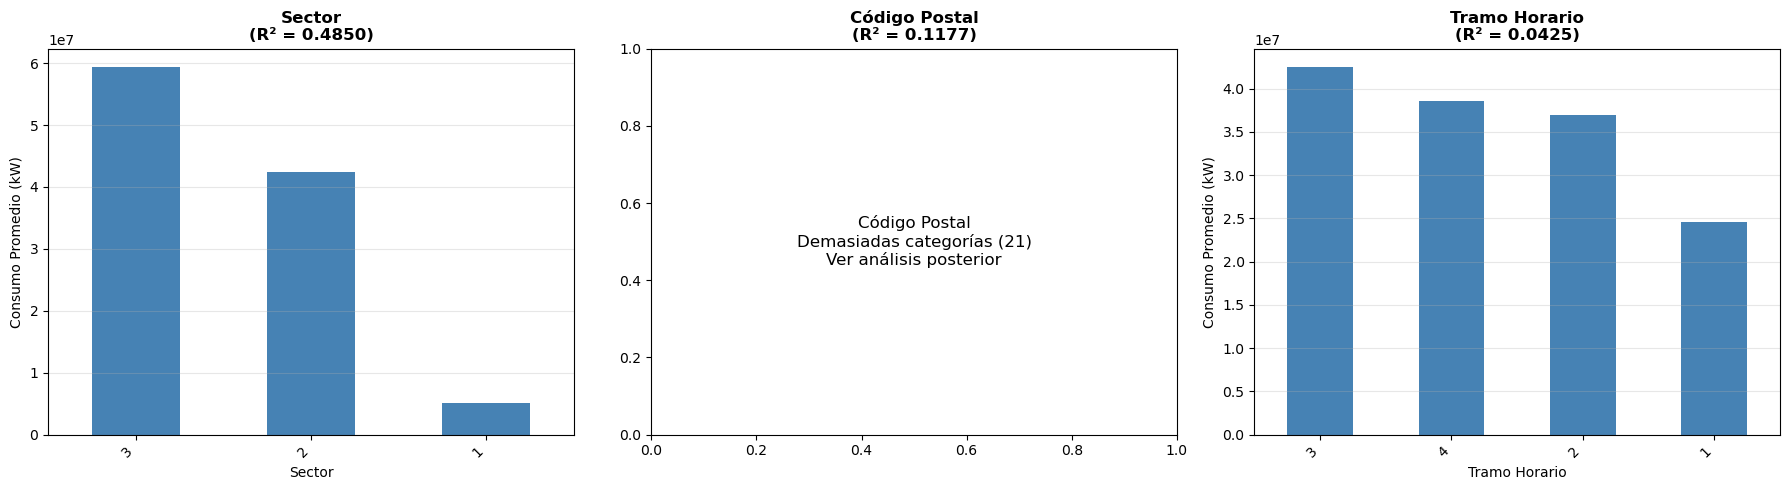

In [5]:
# ============================================================================
# 2. ANÁLISIS DETALLADO DE LAS TOP 3 VARIABLES
# ============================================================================

print("\n" + "=" * 80)
print("📈 2. ANÁLISIS DETALLADO DE TOP 3 VARIABLES")
print("=" * 80)

top3 = df_resultados.head(3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top3.iterrows()):
    ax = axes[idx]
    var_nombre = row['Variable']
    
    # Encontrar el nombre de la columna
    columna = None
    for k, v in {**variables_categoricas, **variables_numericas}.items():
        if k == var_nombre:
            columna = v
            break
    
    if columna and columna in df.columns:
        if row['Tipo'] == 'Categórica':
            # Gráfico de barras para categóricas
            consumo_por_cat = df.groupby(columna)['consumo_kwh'].mean().sort_values(ascending=False)
            
            if len(consumo_por_cat) <= 20:  # Solo si no hay demasiadas categorías
                consumo_por_cat.plot(kind='bar', ax=ax, color='steelblue')
                ax.set_xlabel(var_nombre)
                ax.set_ylabel('Consumo Promedio (kW)')
                ax.set_title(f'{var_nombre}\n(R² = {row["R² Individual"]:.4f})', fontweight='bold')
                ax.grid(axis='y', alpha=0.3)
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            else:
                # Si hay muchas categorías, mostrar distribución
                ax.text(0.5, 0.5, f'{var_nombre}\nDemasiadas categorías ({row["Grupos Únicos"]})\nVer análisis posterior',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{var_nombre}\n(R² = {row["R² Individual"]:.4f})', fontweight='bold')
        else:
            # Scatter plot para numéricas
            ax.scatter(df[columna], df['consumo_kwh'], alpha=0.3, s=10)
            ax.set_xlabel(var_nombre)
            ax.set_ylabel('Consumo (kW)')
            ax.set_title(f'{var_nombre}\n(R² = {row["R² Individual"]:.4f})', fontweight='bold')
            ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


🔄 3. ANÁLISIS DE COMBINACIONES DE VARIABLES

📊 R² de combinaciones de variables:
  • Sector + Horario                         → R² = 0.5531 (55.31%)
  • Sector + mes                             → R² = 0.5089 (50.89%)
  • Horario + Fin de Semana                  → R² = 0.0510 (5.10%)
  • Sector + Horario + mes                   → R² = 0.5799 (57.99%)

🌲 4. IMPORTANCIA DE VARIABLES (Random Forest)

🔧 Entrenando Random Forest con 651,495 registros...

🎯 RANKING DE IMPORTANCIA:
                Variable  Importancia
     id_sector_economico     0.572654
            id_geografia     0.216961
        id_tramo_horario     0.080552
               poblacion     0.055110
temperatura_media_ciudad     0.033294
        es_fin_de_semana     0.023716
                     mes     0.013772
              es_festivo     0.002275
             dia_del_mes     0.001380
    humedad_media_ciudad     0.000287

📊 R² del Random Forest completo: 0.9245 (92.45%)


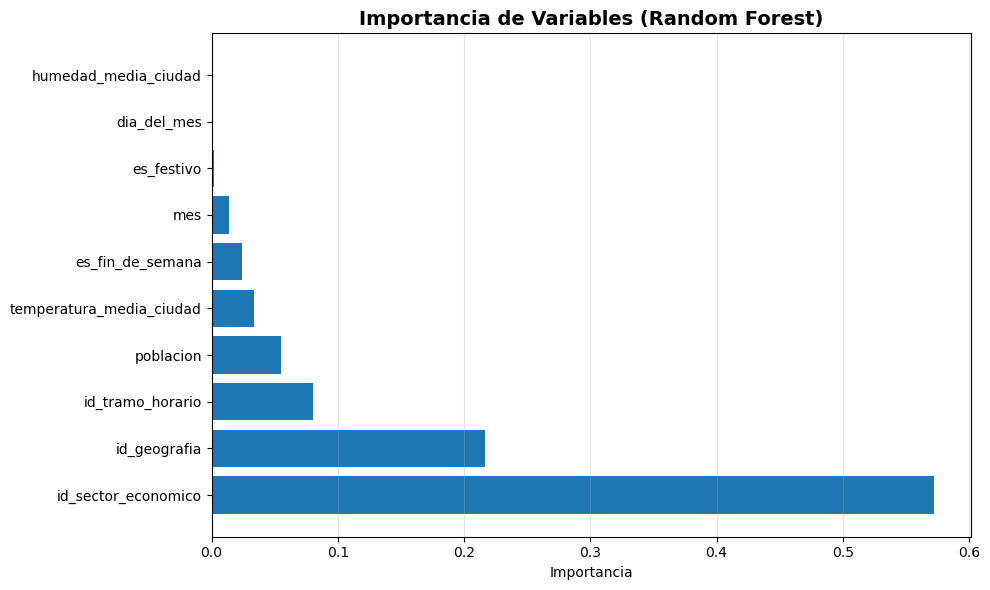

In [6]:
# ============================================================================
# 3. ANÁLISIS DE COMBINACIONES
# ============================================================================

print("\n" + "=" * 80)
print("🔄 3. ANÁLISIS DE COMBINACIONES DE VARIABLES")
print("=" * 80)

# Probar combinaciones importantes
combinaciones = [
    (['id_sector_economico', 'id_tramo_horario'], 'Sector + Horario'),
    (['id_sector_economico', 'mes'], 'Sector + mes'),
    (['id_tramo_horario', 'es_fin_de_semana'], 'Horario + Fin de Semana'),
    (['ID_geografia', 'id_sector_economico'], 'Código Postal + Sector'),
    (['id_sector_economico', 'id_tramo_horario', 'mes'], 'Sector + Horario + mes'),
]

print("\n📊 R² de combinaciones de variables:")

for columnas, nombre in combinaciones:
    # Verificar que todas las columnas existen
    if all(col in df.columns for col in columnas):
        # Crear una clave única combinando las columnas
        df_temp = df[columnas + ['consumo_kwh']].copy()
        df_temp['combinacion'] = df_temp[columnas].astype(str).agg('-'.join, axis=1)
        
        # Predecir usando la media de cada combinación
        media_combinacion = df_temp.groupby('combinacion')['consumo_kwh'].transform('mean')
        r2_comb = r2_score(df_temp['consumo_kwh'], media_combinacion)
        
        print(f"  • {nombre:40} → R² = {r2_comb:.4f} ({r2_comb*100:.2f}%)")

# ============================================================================
# 4. IMPORTANCIA DE VARIABLES CON RANDOM FOREST
# ============================================================================

print("\n" + "=" * 80)
print("🌲 4. IMPORTANCIA DE VARIABLES (Random Forest)")
print("=" * 80)

# Preparar datos para Random Forest
columnas_modelo = []
for col in ['id_sector_economico', 'id_tramo_horario', 'id_geografia', 'mes', 
            'dia_del_mes', 'es_fin_de_semana', 'es_festivo', 'poblacion',
            'temperatura_media_ciudad', 'humedad_media_ciudad']:
    if col in df.columns:
        columnas_modelo.append(col)

df_modelo = df[columnas_modelo + ['consumo_kwh']].dropna()

# Convertir booleanos a int
for col in df_modelo.columns:
    if df_modelo[col].dtype == 'bool':
        df_modelo[col] = df_modelo[col].astype(int)

X = df_modelo[columnas_modelo]
y = df_modelo['consumo_kwh']

print(f"\n🔧 Entrenando Random Forest con {len(X):,} registros...")

# Entrenar Random Forest (con menos estimadores para que sea más rápido)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Obtener importancias
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n🎯 RANKING DE IMPORTANCIA:")
print(importancias.to_string(index=False))

# R² del modelo
r2_rf = rf.score(X, y)
print(f"\n📊 R² del Random Forest completo: {r2_rf:.4f} ({r2_rf*100:.2f}%)")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(importancias)), importancias['Importancia'].values)
ax.set_yticks(range(len(importancias)))
ax.set_yticklabels(importancias['Variable'].values)
ax.set_xlabel('Importancia')
ax.set_title('Importancia de Variables (Random Forest)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# 5. ANÁLISIS DE VARIANZA (ANOVA)
# ============================================================================

print("\n" + "=" * 80)
print("📊 5. ANÁLISIS DE VARIANZA ENTRE GRUPOS")
print("=" * 80)

# Calcular qué porcentaje de la varianza está DENTRO de grupos vs ENTRE grupos
def calcular_varianza_explicada(df, columna_grupo, columna_valor):
    """Calcula qué % de la varianza explica una variable categórica"""
    # Varianza total
    varianza_total = df[columna_valor].var()
    
    # Varianza entre grupos (explicada)
    medias_grupo = df.groupby(columna_grupo)[columna_valor].mean()
    counts_grupo = df.groupby(columna_grupo)[columna_valor].count()
    media_total = df[columna_valor].mean()
    
    varianza_entre = sum(counts_grupo * (medias_grupo - media_total)**2) / len(df)
    
    # Porcentaje explicado
    pct_explicado = (varianza_entre / varianza_total) * 100
    
    return pct_explicado, varianza_total, varianza_entre

print("\n📈 Varianza explicada por cada variable:")

for nombre, columna in variables_categoricas.items():
    if columna in df.columns and df[columna].notna().sum() > 0:
        pct, var_total, var_entre = calcular_varianza_explicada(df, columna, 'consumo_kwh')
        print(f"  • {nombre:25} explica {pct:6.2f}% de la varianza")



📊 5. ANÁLISIS DE VARIANZA ENTRE GRUPOS

📈 Varianza explicada por cada variable:
  • Sector                    explica  48.50% de la varianza
  • Tramo Horario             explica   4.25% de la varianza
  • Fin de Semana             explica   0.59% de la varianza
  • Festivo                   explica   0.10% de la varianza
  • Mes                       explica   0.78% de la varianza
  • Día del Mes               explica   0.02% de la varianza
  • Código Postal             explica  11.77% de la varianza
  • Año                       explica   0.18% de la varianza


In [9]:
# ============================================================================
# 6. DIAGNÓSTICO Y RECOMENDACIONES
# ============================================================================

print("\n" + "=" * 80)
print("💡 DIAGNÓSTICO Y RECOMENDACIONES")
print("=" * 80)

# Identificar la variable más importante
var_mas_importante = df_resultados.iloc[0]
r2_max = var_mas_importante['R² Individual']

print(f"\n🎯 HALLAZGOS PRINCIPALES:")
print(f"\n1. Variable más predictiva: {var_mas_importante['Variable']}")
print(f"   → Explica {r2_max*100:.2f}% de la variación")

if r2_max < 0.1:
    print(f"\n⚠️ PROBLEMA DETECTADO: Ninguna variable individual explica >10% del consumo")
    print(f"\n   Posibles causas:")
    print(f"   • El consumo tiene MUCHA variabilidad aleatoria")
    print(f"   • Falta información importante (ej: tipo de edificio, m², equipamiento)")
    print(f"   • Los datos están muy agregados (promediando muchos casos diferentes)")
    print(f"   • Hay muchos outliers o errores en los datos")
    
    print(f"\n   🔍 Próximos pasos:")
    print(f"   1. Revisar distribución del consumo (buscar outliers)")
    print(f"   2. Analizar si hay segmentos con comportamiento más predecible")
    print(f"   3. Considerar features de interacción (combinaciones)")
    print(f"   4. Evaluar si necesitas más variables explicativas")

elif r2_max < 0.5:
    print(f"\n✅ Hay factores importantes pero no dominantes")
    print(f"\n   Recomendaciones:")
    print(f"   • Usar modelos con múltiples variables")
    print(f"   • Explorar interacciones entre variables")
    print(f"   • Segmentar el análisis por grupos (ej: por sector)")

else:
    print(f"\n✅ Hay un factor dominante claramente identificado")
    print(f"\n   Enfoca tu análisis en: {var_mas_importante['Variable']}")

# Estadísticas básicas del consumo
print(f"\n📊 ESTADÍSTICAS DEL CONSUMO:")
print(f"   • Media: {df['consumo_kwh'].mean():,.0f} kW")
print(f"   • Mediana: {df['consumo_kwh'].median():,.0f} kW")
print(f"   • Desv. Estándar: {df['consumo_kwh'].std():,.0f} kW")
print(f"   • Coef. Variación: {(df['consumo_kwh'].std() / df['consumo_kwh'].mean() * 100):.1f}%")
print(f"   • Rango: {df['consumo_kwh'].min():,.0f} - {df['consumo_kwh'].max():,.0f} kW")

# Si el coeficiente de variación es muy alto
cv = df['consumo_kwh'].std() / df['consumo_kwh'].mean() * 100
if cv > 100:
    print(f"\n   ⚠️ Coeficiente de variación MUY ALTO ({cv:.1f}%)")
    print(f"   → Los datos son muy heterogéneos, considera segmentar el análisis")

print("\n" + "=" * 80)


💡 DIAGNÓSTICO Y RECOMENDACIONES

🎯 HALLAZGOS PRINCIPALES:

1. Variable más predictiva: Sector
   → Explica 48.50% de la variación

✅ Hay factores importantes pero no dominantes

   Recomendaciones:
   • Usar modelos con múltiples variables
   • Explorar interacciones entre variables
   • Segmentar el análisis por grupos (ej: por sector)

📊 ESTADÍSTICAS DEL CONSUMO:
   • Media: 35,651,433 kW
   • Mediana: 33,004,000 kW
   • Desv. Estándar: 32,523,318 kW
   • Coef. Variación: 91.2%
   • Rango: 1,000 - 891,516,000 kW

